In [1]:
import requests
import json
from datetime import datetime, timedelta, timezone
import pandas as pd
import os
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Functions


In [3]:
import os
import pandas as pd

# Merge files
def merge_csv_files(directory_path):

    """
    Merges all CSV files in a directory into a single pandas DataFrame.

    Args:
    directory_path (str): The directory path containing the CSV files.

    Returns:
    merged_df (pandas.DataFrame): The merged pandas DataFrame of all CSV files in the directory.
    """
    dfs = []

    # loop through each file in the directory
    for file in os.listdir(directory_path):
        # check if the file is a CSV file
        if file.endswith(".csv"):
            file_path = os.path.join(directory_path, file)
            if directory_path.endswith("dataverse_file"):
                df = pd.read_csv(file_path, delimiter=",")
            else:
                df = pd.read_csv(file_path, delimiter=";")
            dfs.append(df)

    # concatenate all dataframes
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df

## Get historical air quality data

In [11]:
# Get air quality data for Leuven
# Period: Jan 1, 2022 to Dec 31, 2022
api_key = "ec722f11f234fb9a316e2580e6e2019e"
lat = 50.88
lon = 4.7
start_date = "1640995200"
end_date = "1672531200"

url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start_date}&end={end_date}&appid={api_key}"
# url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}"
# url = f"http://api.openweathermap.org/data/2.5/air_pollution/forecast?lat={lat}&lon={lon}&appid={api_key}"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
else:
    print("Error:", response.status_code)

In [17]:
# Historical
df = pd.DataFrame(data["list"])
df["dt"] = pd.to_datetime(df["dt"], unit="s")
components_df = pd.json_normalize(df["components"])
aqi_df = pd.json_normalize(df["main"])
df = pd.concat([df, components_df, aqi_df], axis=1)
df.drop(["components", "main"], axis=1, inplace=True)
df.head(10)

,dt,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
0,2022-01-01 00:00:00,253.68,0.00,8.83,39.34,1.82,3.68,5.20,0.79,1
1,2022-01-01 01:00:00,250.34,0.00,8.05,38.62,1.86,3.69,5.27,0.79,1
2,2022-01-01 02:00:00,247.00,0.00,7.11,38.27,1.71,3.44,4.99,0.78,1
3,2022-01-01 03:00:00,243.66,0.00,6.17,38.62,1.33,2.93,4.26,0.72,1
4,2022-01-01 04:00:00,257.02,0.00,6.85,37.19,1.03,3.02,4.07,0.68,1
5,2022-01-01 05:00:00,290.39,0.00,10.11,32.54,0.95,4.49,5.46,0.69,1
6,2022-01-01 06:00:00,330.45,0.02,15.42,26.82,1.18,6.74,7.79,0.73,1
7,2022-01-01 07:00:00,337.12,0.04,18.68,23.96,1.48,7.13,8.26,0.76,1
8,2022-01-01 08:00:00,307.08,0.04,18.16,25.03,1.64,5.74,6.81,0.71,1
9,2022-01-01 09:00:00,273.70,0.09,15.42,28.61,1.59,4.23,5.20,0.66,1


## Process air quality data

In [18]:
air_quality_data = df

# Format time stamp
air_quality_data["dt"] = pd.to_datetime(air_quality_data["dt"])
air_quality_data["date"] = air_quality_data["dt"].dt.date
air_quality_data["hour"] = air_quality_data["dt"].dt.hour
air_quality_data["month"] = air_quality_data["dt"].dt.month
air_quality_data["weekday"] = air_quality_data["dt"].dt.strftime("%a")

air_quality_data.to_csv("../data/processed_air_quality_data.csv")

## Get historical traffic data

In [27]:
url = "https://telraam-api.net/v1/reports/traffic"
headers = {"X-Api-Key": "Z9Qoyuy9Yf99nf2I0Myig4t0ftuUmY81ahBIVZH4"}

start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2023-01-01")

# define the duration for each loop (3 months)
loop_duration = pd.DateOffset(months=3)

# define the list of sensor IDs
counter_ids = [
    "9000000627",
    "347690",
    "9000000674",
    "9000000773",
    "347931",
    "347860",
    "9000000764",
    "9000000672",
    "347948",
    "9000001547",
    "347365",
    "349054",
    "9000000681",
]

full_data = pd.DataFrame()

# loop through the counter IDs
for counter_id in counter_ids:
    # retrieve data for each 3-month period
    current_date = start_date
    while current_date < end_date:
        loop_start_date = current_date
        loop_end_date = loop_start_date + loop_duration

        body = {
            "id": counter_id,
            "time_start": loop_start_date.strftime("%Y-%m-%d %H:%M:%SZ"),
            "time_end": loop_end_date.strftime("%Y-%m-%d %H:%M:%SZ"),
            "level": "segments",
            "format": "per-hour",
        }
        payload = str(body)

        response = requests.post(url, headers=headers, data=payload)
        json_data = response.json()
        loop_data = pd.DataFrame(json_data["report"])
        full_data = pd.concat([full_data, loop_data])

        # update the current date for the next loop
        current_date += loop_duration

In [24]:
location = {
    "9000000627": "redingenhof",
    "347690": "Kapucijnenvoer",
    "9000000674": "Tiensestraat",
    "9000000773": "Bondgenotenlaan",
    "347931": "Vital Decostersstraat",
    "347860": "BROUWERSSTRAAT",
    "9000000764": "Fonteinstraat 137 b 301",
    "9000000672": "Petermannenstraat",
    "347948": "Ridderstraat",
    "9000001547": "Jan Pieter Minckelersstraat",
    "347365": "Dekenstraat",
    "349054": "Pleinstraat",
    "9000000681": "Bierbeekstraat",
}

In [40]:
full_data["location"] = full_data.segment_id.astype("str").map(location)
full_data.to_csv("../data/traffic_leuven_2022.csv", index=False)

In [44]:
full_data

,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,heavy_lft,...,bike_lft,bike_rgt,pedestrian_lft,pedestrian_rgt,direction,car_speed_hist_0to70plus,car_speed_hist_0to120plus,timezone,v85,location
0,-1,9000000627,2022-01-01T00:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
1,-1,9000000627,2022-01-01T01:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
2,-1,9000000627,2022-01-01T02:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
3,-1,9000000627,2022-01-01T03:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
4,-1,9000000627,2022-01-01T04:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,-1,9000000681,2022-12-31T19:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,Bierbeekstraat
2202,-1,9000000681,2022-12-31T20:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,Bierbeekstraat
2203,-1,9000000681,2022-12-31T21:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,Bierbeekstraat
2204,-1,9000000681,2022-12-31T22:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,Bierbeekstraat


## Get historical weather data

In [5]:
def get_forecast_hourly_weather(url):
    resp = requests.get(url)
    data = resp.json()
    df = pd.DataFrame(data["hourly"])
    return df

In [6]:
url = "https://archive-api.open-meteo.com/v1/archive?latitude=50.88&longitude=4.70&start_date=2022-01-01&end_date=2022-12-31&timezone=Europe%2FBerlin&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m"
weather_data = get_forecast_hourly_weather(url)

## Process historical weather data

In [9]:
## rename the column
weather_data.columns = [re.sub(" \(.*\)", "", col) for col in weather_data.columns]

# Format time stamp
weather_data["time"] = pd.to_datetime(weather_data["time"])
weather_data["date"] = weather_data["time"].dt.date
weather_data["hour"] = weather_data["time"].dt.hour
weather_data["month"] = weather_data["time"].dt.month
weather_data["weekday"] = weather_data["time"].dt.strftime("%a")

weather_data.to_csv("../data/processed_weather_data_leuven.csv")

<AxesSubplot:>

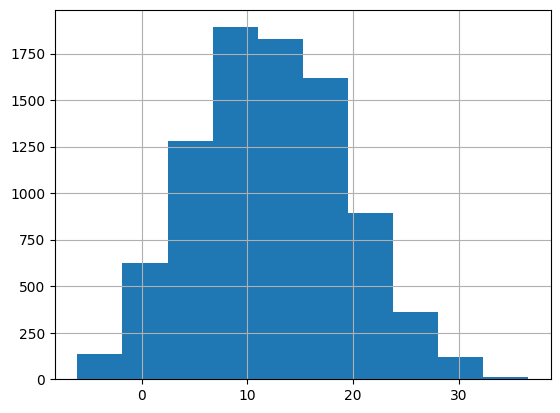

In [10]:
weather_data["temperature_2m"].hist()

## Process file 40 

In [ ]:
file40 = merge_csv_files("../data/file_40")

In [7]:
### we would delete unit column because of same values
# drop all _unit columns
cols_to_drop = [col for col in file40.columns if col.endswith("unit")]
file40.drop(cols_to_drop, axis=1, inplace=True)

# rename columns
file40.rename(
    columns={"description": "location", "#object_id": "object_id"}, inplace=True
)

# Convert the 'result_timestamp' column to a datetime data type
file40["result_timestamp"] = pd.to_datetime(file40["result_timestamp"])
file40["date"] = file40["result_timestamp"].dt.date
file40["hour"] = file40["result_timestamp"].dt.hour
file40["month"] = file40["result_timestamp"].dt.month
file40["weekday"] = file40["result_timestamp"].dt.strftime("%a")

file40.to_csv("../data/processed_file40_data.csv")

## Process file 41

In [11]:
# Merge files
file41 = merge_csv_files("../data/file_41")

In [12]:
# drop unncessary cols
cols_to_drop = [
    "noise_event_laeq_model_id_unit",
    "noise_event_laeq_model_id",
    "noise_event_laeq_primary_detected_certainty_unit",
    "noise_event_laeq_primary_detected_class_unit",
]

file41.drop(cols_to_drop, axis=1, inplace=True)

# rename cols
file41.columns = [
    "object_id",
    "location",
    "result_timestamp",
    "noise_event_certainty",
    "noise_event",
]

# remove the noise_event that are unsupported
file41 = file41.loc[file41.noise_event != "Unsupported"]

In [13]:
# extract from timestamp
file41["result_timestamp"] = pd.to_datetime(file41["result_timestamp"])
file41["time"] = file41["result_timestamp"].dt.time
file41["date"] = file41["result_timestamp"].dt.date
file41["hour"] = file41["result_timestamp"].dt.hour
file41["month"] = file41["result_timestamp"].dt.month
file41["weekday"] = file41["result_timestamp"].dt.strftime("%a")

In [14]:
# Only adding datapoints with certanity of 85%+
file41 = pd.DataFrame(file41.loc[file41["noise_event_certainty"] > 85].reset_index())
# Dropping undefined columns
file41 = file41.dropna(subset=["noise_event"])
# Pivot table to transform into counting hourly types of noise events
file41_piv = (
    pd.pivot_table(
        file41,
        index=["object_id", "date", "hour", "month", "weekday"],
        columns=["noise_event"],
        aggfunc="count",
    )
    .xs("location", level=0, axis=1)
    .reset_index()
)
file41_piv.fillna(0, inplace=True)

file41_piv.to_csv("../data/processed_file41_data")

## Process file 42

In [19]:
object_id_dict = {
    255439: "MP 01: Naamsestraat 35 Maxim",
    255440: "MP 02: Naamsestraat 57 Xior",
    255441: "MP 03: Naamsestraat 62 Taste",
    303910: "MP 04: His & Hears",
    255442: "MP 05: Calvariekapel KU Leuven",
    255443: "MP 06: Parkstraat 2 La Filosovia",
    255444: "MP 07: Naamsestraat 81",
    280324: "MP08bis - Vrijthof",
}

In [20]:
# Process all dataset within a month folder (export 42 data)
def process_data_month_folder(folder_path):
    """
    Process data from a folder containing CSV files and concatenate the results.

    Parameters:
        folder_path (str): Path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: Concatenated DataFrame containing the processed data.

    """

    concatenated_df = pd.DataFrame()

    folder_files = os.listdir(folder_path)

    # process each file in the folder
    for file_name in folder_files:
        file_path = os.path.join(folder_path, file_name)
        if file_path.endswith("csv"):
            print(f"Processing: {file_path}")
            df = pd.read_csv(file_path, delimiter=";")
            # convert 'result_timestamp' to datetime format
            df["result_timestamp"] = pd.to_datetime(
                df["result_timestamp"], format="%d/%m/%Y %H:%M:%S.%f"
            )
            # set 'result_timestamp' as the index
            df.set_index("result_timestamp", inplace=True)
            # resample to hourly frequency and calculate the mean
            df_resampled = df.resample("H").mean()
            # reset index and add additional columns
            df_resampled.reset_index(inplace=True)
            df_resampled["date"] = df_resampled["result_timestamp"].dt.date
            df_resampled["hour"] = df_resampled["result_timestamp"].dt.hour
            df_resampled["weekday"] = df_resampled["result_timestamp"].dt.strftime("%a")
            df_resampled["month"] = df_resampled["result_timestamp"].dt.month
            # drop rows with NaN values in 'lamax' column
            df_resampled.dropna(subset=["lamax"], inplace=True)
            # rename column and convert 'object_id' to int
            df_resampled.rename(columns={"#object_id": "object_id"}, inplace=True)
            df_resampled["object_id"] = df_resampled["object_id"].astype(int)
            # ddd location column using 'object_id_dict'
            df_resampled["location"] = df_resampled["object_id"].map(object_id_dict)
            # concatenate
            concatenated_df = pd.concat([concatenated_df, df_resampled])
            concatenated_df = concatenated_df[
                [
                    "result_timestamp",
                    "object_id",
                    "lamax",
                    "laeq",
                    "lceq",
                    "lcpeak",
                    "date",
                    "hour",
                    "weekday",
                    "month",
                    "location",
                ]
            ]

    return concatenated_df

In [21]:
file42_april = process_data_month_folder(
    "April"
)  # this folder is removed after we finished with concatting

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'April'

In [12]:
file42_april.head(5)

,result_timestamp,object_id,lamax,laeq,lceq,lcpeak,date,hour,weekday,month,location
0,2022-04-01 00:00:00,255439,66.120833,63.600472,68.268761,81.020408,2022-04-01,0,Fri,4,MP 01: Naamsestraat 35 Maxim
1,2022-04-01 01:00:00,255439,70.415667,68.026639,71.393108,84.233783,2022-04-01,1,Fri,4,MP 01: Naamsestraat 35 Maxim
2,2022-04-01 02:00:00,255439,69.295972,66.801806,70.874731,83.634528,2022-04-01,2,Fri,4,MP 01: Naamsestraat 35 Maxim
3,2022-04-01 03:00:00,255439,66.675556,64.217861,69.030939,81.704456,2022-04-01,3,Fri,4,MP 01: Naamsestraat 35 Maxim
4,2022-04-01 04:00:00,255439,64.581167,61.840000,66.902536,79.723325,2022-04-01,4,Fri,4,MP 01: Naamsestraat 35 Maxim


In [8]:
# To merge all csv that starts with file42
def concat_file42_datasets(folder_path):
    files = os.listdir(folder_path)

    # filter csv that start with "file42"
    file42_files = [
        file for file in files if file.startswith("file42") and file.endswith("csv")
    ]

    merged_df = pd.DataFrame()

    for file in file42_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, delimiter=";")
        merged_df = pd.concat([merged_df, df], ignore_index=True)

    return merged_df

In [ ]:
file42 = concat_file42_datasets()
file42.to_csv("../data/processed_file42.csv")